<a href="https://colab.research.google.com/github/rdemitri/data-science-python-youtube/blob/master/NLP_Aula_IV_Redes_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Redes Neurais Recorrentes - LSTM (Long short term memory)** 

Veja que a cada palavra lida deste material nós conectamos a palavra atual ao contexto e conteudo passado anteriormente, na mesma  frase, mesmo capitulo de um livro, mesma história. Isto dá sentido as palavras. 

Um problema das redes neurais que vimos até agora, até mesmo redes neurais recorrentes é que o contexto e o aprendizado passado não transitam entre a rede. E é neste ponto que entram as redes neurais recorrentes LSTM.

---




Redes neurais recorrentes, como neste exemplo LSTM são boas em analisar sequências de valores e prever o próximo valor. Seu uso vai desde textos, já que temos uma sequencia de palavras, até uso em previsão de demanda, forecast de modo geral. 

Em textos, passamos toda sequencia de palavras de forma que a rede entenda usando algumas das abordagens passadas nesta aula, e o esperado é que a rede aprenda a forma de escrita no treinamento e possa reproduzir. 

Podemos representar o texto como uma sequência de caracteres ou uma sequência de palavras, o modelo será capaz de inferir o próximo caracter ou a próxima palavra.

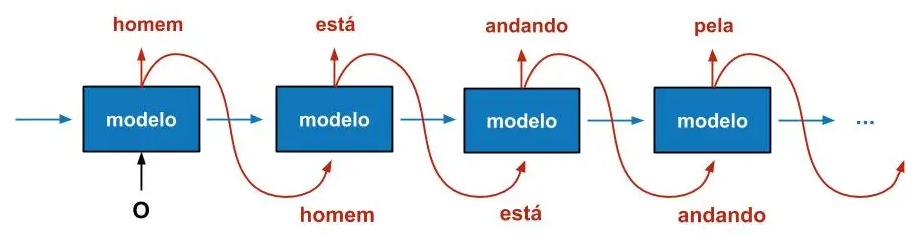



A rede LSTM recebe uma palavra de entrada, faz a previsão da próxima palavra, esta palavra gerada serve de entrada para a proxima etapa.

A geração dos textos passam por cinco etapas: 

1. Definição de uma sequencia de palavras iniciais que servirão como base (seed)
2. previsão da probabilidade de cada palavra do vocabulário ser a próxima da frase de entrada.
3. Escolha da palavra com maior probabilidade.
4. Anexar nova palavra a frase inicial.
5. Repetir o processo a partir da etapa 2 até gerar n novas palavras.

Inicialmente definimos o seed e passamos para a rede criar novas palavras e completar a frase/texto palavra por palavra.

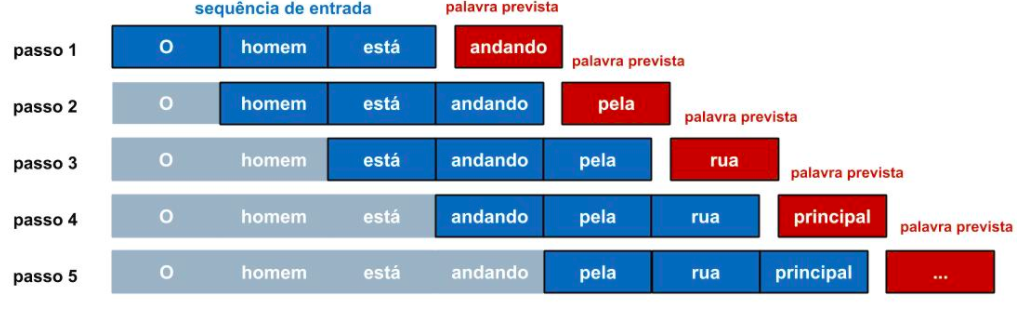


### **Arquitetura da Rede LSTM**

Na nossa rede neural usaremos na camada de entrada ou one-hot vectors ou embeddings, mas a camada de saida será uma só contendo um neuronio para cada palavra do vocabulário. Logo, nossa saida é um vetor do tamanho do vocabulario, neste caso abaixo 10 contendo a probabilidade daquela palavra do neuronio ser a próxima palavra da frase.
Como de costume, temos uma camada Densa no final da rede com ativação softmax.

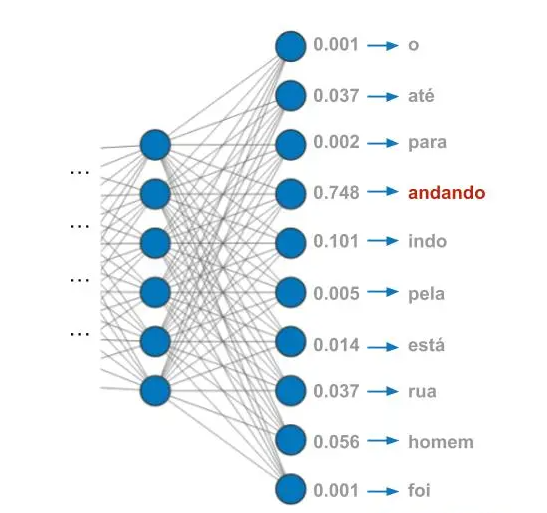




### **Vetorização One-Hot**

Quando usamos one-hot vectors, cada palavra será representada por um vetor do tamanho do vocabulário onde somente uma posição será 1 (Lembrem do One-Hot Encoding das aulas de Classificação e Regressão Linear).

Cada instância de entrada é um um vetor one hot, no exemplo abaixo com três palavras com o shape (n_palavras, n_palavras_vocabulario). As camadas da rede LSTM intera sobre a sequencia de palavras, e produz saidas se tivermos uma rede simples com duas camadas como no exemplo, definimos return_sequences=False, caso a rede seja maior e mais complexas return_sequences deve ser definido como True.




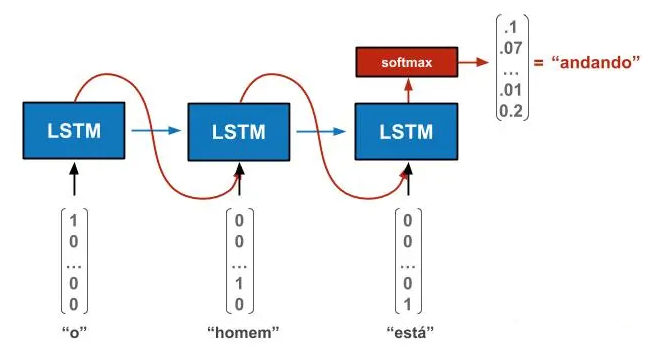

### **Vetorização Word Embedding** 

Nesta abordagem passamos como entrada uma sequencia de tokens correspondentes as palavras, as entradas agora possuem o shape (n_palavras_entrada, 1). A camada Embedding aprende uma representação eficiente para cada token e passa essa representação para as camadas LSTM seguintes. Com isto cada camada processa como de costume chegando a camada Densa que aplica a função softmax.

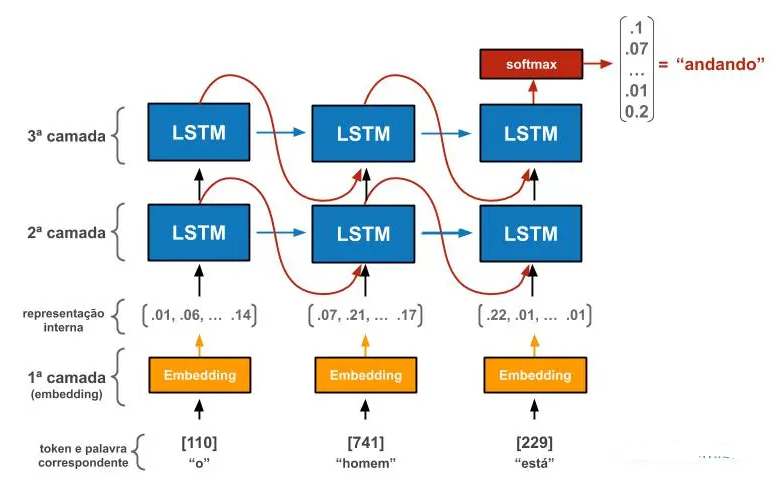

In [ ]:
# Importando as bibliotecas 
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from keras import layers 

import io 
import matplotlib.pyplot as plt 
import re 
import string 
import numpy as np 

## **Dataset** 

Vamos trabalhar com um conjunto de textos de Nietzsche, vamos baixa-los através do script abaixo.

In [ ]:
path = get_file(
    'nietzsche.txt', 
    origin = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt')
with io.open(path, encoding='utf-8') as f:
  text = f.read().lower()
print('Corpus lenght: {}'.format(len(text)))

600901/600901 [==============================] - 0s 1us/step
Corpus lenght: 600893


## **Tratamento do corpus**

In [ ]:
text = text.lower()  # Transforma em minusculo
text = text.replace('\n', '')
text_words = [w for w in text.split(' ') if w.strip() != '' or w == '\n']
print('Quantidade de palavras: {}'.format(len(text_words)))
print(text_words[:20])

Quantidade de palavras: 90192
['prefacesupposing', 'that', 'truth', 'is', 'a', 'woman--what', 'then?', 'is', 'there', 'not', 'groundfor', 'suspecting', 'that', 'all', 'philosophers,', 'in', 'so', 'far', 'as', 'they']


#### **Criando Vocabulário**

In [ ]:
vocab_size = 500

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>', filters='[^\x00-\x7f]')
tokenizer.fit_on_texts(text_words) 
tokens = tokenizer.texts_to_sequences(text_words)
tokens = [int(t[0]) for t in tokens]
print(text_words[:10])
print(tokens[:10])

['prefacesupposing', 'that', 'truth', 'is', 'a', 'woman--what', 'then?', 'is', 'there', 'not']
[1, 9, 166, 8, 7, 158, 1, 8, 35, 15]


#### **Separação entre X e y**

Após tokenizar as sentenças vamos agrupar as palavras criando sub-sequencias de entrada ***X*** e suas respectivas saidas, ou seja as palavras seguintes ***Y***.
Quando fazemos esse slice, podemos definir um intervalo entre cada step, isso reduz a produção de sequencias com palavras sobrepostas e repetidas.

In [ ]:
step = 1 
sentences = [] # Será nosso X
next_word = [] # Será nosso y
seq_len = 20 # Numero de tokens por frase de X
for i in range(0, len(tokens) - seq_len, step):
  sentences.append(tokens[i: i + seq_len])
  next_word.append(tokens[i + seq_len])

print('Instancias para treinamento: {}'.format(len(sentences)))
for i in range(5):
  print(sentences[i], '--->', next_word[i])

Instancias para treinamento: 90172
[1, 9, 166, 8, 7, 158, 1, 8, 35, 15, 1, 1, 9, 18, 1, 6, 37, 105, 10, 29] ---> 28
[9, 166, 8, 7, 158, 1, 8, 35, 15, 1, 1, 9, 18, 1, 6, 37, 105, 10, 29, 28] ---> 1
[166, 8, 7, 158, 1, 8, 35, 15, 1, 1, 9, 18, 1, 6, 37, 105, 10, 29, 28, 1] ---> 28
[8, 7, 158, 1, 8, 35, 15, 1, 1, 9, 18, 1, 6, 37, 105, 10, 29, 28, 1, 28] ---> 1
[7, 158, 1, 8, 35, 15, 1, 1, 9, 18, 1, 6, 37, 105, 10, 29, 28, 1, 28, 1] ---> 5


#### **One Hot Vector**

Agora vamos codificar os tokens usando one-hot, ao termino da codificação cada token será um vetor de 500 dimensões. 

In [ ]:
X_train = np.array(sentences)
y_train = np.array(next_word)
print('Shape de X_train {}'.format(X_train.shape))
print('Shape de y_train {}'.format(y_train.shape))

Shape de X_train (90172, 20)
Shape de y_train (90172,)


In [ ]:
X_train_ohe = to_categorical(X_train, num_classes=vocab_size)
y_train_ohe = to_categorical(y_train, num_classes=vocab_size)
print('Shape de X_train_ohe {}'.format(X_train_ohe.shape))
print('Shape de y_train_ohe {}'.format(y_train_ohe.shape))

Shape de X_train_ohe (90172, 20, 500)
Shape de y_train_ohe (90172, 500)


Tinhamos 90172 frases de 20 tokens cada. Após o One Hot Vectors temos 90172 x 20 x 500. 

## **Modelo LSTM**

In [ ]:
model = keras.Sequential([
    layers.LSTM(64, input_shape=(seq_len, vocab_size), return_sequences=False,),
    layers.Dense(vocab_size, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                144640    
                                                                 
 dense (Dense)               (None, 500)               32500     
                                                                 
Total params: 177,140
Trainable params: 177,140
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_history = model.fit(X_train_ohe, y_train_ohe, validation_split=0.2, epochs=30, batch_size=128)

Epoch 1/30
564/564 [==============================] - 28s 47ms/step - loss: 3.7781 - accuracy: 0.3828 - val_loss: 3.7003 - val_accuracy: 0.3750
Epoch 2/30
564/564 [==============================] - 27s 49ms/step - loss: 3.6078 - accuracy: 0.3863 - val_loss: 3.6415 - val_accuracy: 0.3750
Epoch 3/30
564/564 [==============================] - 26s 47ms/step - loss: 3.5449 - accuracy: 0.3863 - val_loss: 3.5896 - val_accuracy: 0.3750
Epoch 4/30
564/564 [==============================] - 26s 46ms/step - loss: 3.4922 - accuracy: 0.3863 - val_loss: 3.5537 - val_accuracy: 0.3750
Epoch 5/30
564/564 [==============================] - 26s 47ms/step - loss: 3.4455 - accuracy: 0.3867 - val_loss: 3.5094 - val_accuracy: 0.3769
Epoch 6/30
564/564 [==============================] - 28s 50ms/step - loss: 3.4038 - accuracy: 0.3896 - val_loss: 3.4786 - val_accuracy: 0.3784
Epoch 7/30
564/564 [==============================] - 27s 47ms/step - loss: 3.3674 - accuracy: 0.3907 - val_loss: 3.4523 - val_accuracy:

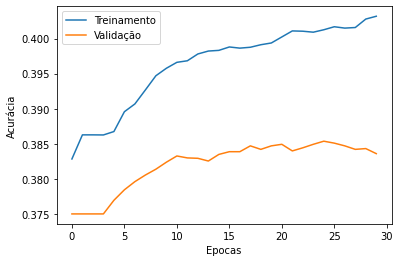

In [ ]:
plt.plot(train_history.history['accuracy'], label='Treinamento')
plt.plot(train_history.history['val_accuracy'], label='Validação')
plt.xlabel('Epocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

## **Predição de novas palavras**



In [ ]:
seed_text = ['Danger'] # Palavra Inicial
seed_token = tokenizer.texts_to_sequences(seed_text[0]) #Substitui a palavra pelo token
X_token = pad_sequences([seed_token], maxlen=seq_len,)
X_token = to_categorical(X_token, num_classes=vocab_size) # One Hot
pred = model.predict(X_token)[0]
print('Quantidade de probabilidades {}'.format(len(pred)))
print(pred[:4])

1/1 [==============================] - 0s 17ms/step
Quantidade de probabilidades 500
[2.4099873e-09 3.0585620e-01 3.1331822e-02 4.5648005e-02]


In [ ]:
next_token = np.argmax(pred,)
next_word = tokenizer.sequences_to_texts([[next_token]])
print('Próximo Token ', next_token, '--->', next_word)

Próximo Token  1 ---> ['<OOV>']


In [ ]:
def sample_word(pred, temperature=1.0):
  pred = pred / temperature
  pred_token = tf.random.categorical(pred, 1).numpy()
  return pred_token

##### Função para gerar textos

In [ ]:
def txt_generate(txt_input, text_words):

  seed_text = txt_input
  next_words = text_words # próximas palavras
  # substitui palavras por tokens
  seed_tokens = tokenizer.texts_to_sequences(seed_text)[0] # substitui palavras por tokens
  print(seed_text, ' tokenizado fica: ', seed_tokens)
  for _ in range(next_words):
      # preenche sequencia com zeros para ter o comprimento adequado pra rede
      tokens_x = pad_sequences([seed_tokens], maxlen=seq_len, )
      # transforma tokens em vetor one-hot
      tokens_x = to_categorical(tokens_x, num_classes=vocab_size) # one hot
      # preve probabilidades para a proxima palavra
      pred_y = model.predict(tokens_x)
      # faz amostragem com base nas probabilidades
      next_token = sample_word(pred_y, 0.2)
      next_token = next_token.flatten()[0] # pega valor como um int
      # anexa token a lista
      seed_tokens.append(next_token) 
      
  # como a saída é um conjunto de tokens
  # realiza a inversão para palavras, usando word_index
  resultado = tokenizer.sequences_to_texts([seed_tokens])
  print('\n')
  return resultado[0]

In [ ]:
txt_generate('This is Danger', 100)

This is Danger  tokenizado fica:  [1]
1/1 [==============================] - 0s 17ms/step




'<OOV> conduct according to god, like fact down once good however, question account not men than right does point here bring were sense done very europe, life, mankind and stand its act seem man philosophical short, seems say who, under can joy very speak self good <OOV> anything give whoever even therefore justice self just him. absolute lower great during possible which, soul again life pain master expression present <OOV> therefore thus them, finally mind <OOV> feel make mean bring present our found eye true sympathy his therefore actions more up one heart before much self natural thought been whatever will'

# **Exercício de hoje**

Treine uma rede LSTM com textos de Jose Alencar da obra Viuvinha que esta no Classroom.